# IMU Case

In [1]:
%load_ext autoreload
%autoreload 2

## 1. Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import pickle as pkl

In [3]:
# --- Parameters ---
WINDOW_SIZE = 400
STEP_SIZE = 200

# --- Load All Data and Split Based on ID ---
all_files = ["data/IMU_case_dataset_part1_.csv",
             "data/IMU_case_dataset_part2_.csv",
             "data/IMU_case_dataset_part3_.csv",
             "data/IMU_case_dataset_part4_.csv"]

dfs = []
for file in all_files:
    df = pd.read_csv(file)
    # Keep the necessary columns: 'X', 'Y', 'Z', 'activity', and 'ID'
    df = df[['X','Y','Z','activity','ID']]
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

# Ensure that the 'ID' column is numeric
data['ID'] = pd.to_numeric(data['ID'], errors='coerce')

# Split the dataset:
# Training data: IDs from 1 to 30
# Testing data: IDs from 31 to 36
train_data = data[data['ID'].between(1, 30)]
test_data  = data[data['ID'].between(31, 36)]

print("Total records:", data.shape[0])
print("Train records:", train_data.shape[0])
print("Test records:", test_data.shape[0])

# --- Normalization ---
# Compute normalization parameters (mean and std) on the training set:
mean_vals = train_data[['X','Y','Z']].mean()
std_vals = train_data[['X','Y','Z']].std()

# Apply normalization to both training and test data:
train_data[['X','Y','Z']] = (train_data[['X','Y','Z']] - mean_vals) / std_vals
test_data[['X','Y','Z']]  = (test_data[['X','Y','Z']]  - mean_vals) / std_vals

# --- Windowing Function ---
def generate_windows(df):
    X_windows = []
    y_labels = []
    # Assuming the dataframe is sorted by time
    for start in range(0, len(df) - WINDOW_SIZE + 1, STEP_SIZE):
        window = df.iloc[start : start + WINDOW_SIZE]
        labels = window["activity"]
        if labels.isna().all():
            # Completely unlabeled window
            X_windows.append(window[["X", "Y", "Z"]].values)
            y_labels.append(None)
        else:
            unique_labels = labels.dropna().unique()
            if len(unique_labels) == 1:
                X_windows.append(window[["X", "Y", "Z"]].values)
                y_labels.append(unique_labels[0])
            else:
                # Mixed or transitional window is treated as unlabeled
                X_windows.append(window[["X", "Y", "Z"]].values)
                y_labels.append(None)
    return X_windows, y_labels

# --- Generate Windows from Training and Test Data ---
# For training data:
train_X_all, train_y_all = generate_windows(train_data)
# Separate into labeled and unlabeled windows:
train_labeled_X = [x for x, y in zip(train_X_all, train_y_all) if y is not None]
train_labeled_y = [y for y in train_y_all if y is not None]
train_unlabeled_X = [x for x, y in zip(train_X_all, train_y_all) if y is None]

# Convert to numpy arrays:
train_labeled_X = np.array(train_labeled_X)   # shape: (N_labeled, 400, 3)
train_labeled_y = np.array(train_labeled_y)     # shape: (N_labeled,)
train_unlabeled_X = np.array(train_unlabeled_X) # shape: (N_unlabeled, 400, 3)

# Remove windows with any NaN features (if any)
not_nan_idx = np.isnan(train_labeled_X).sum(axis=-1).sum(axis=-1) == 0
train_labeled_X = train_labeled_X[not_nan_idx]
train_labeled_y = train_labeled_y[not_nan_idx]

not_nan_idx = np.isnan(train_unlabeled_X).sum(axis=-1).sum(axis=-1) == 0
train_unlabeled_X = train_unlabeled_X[not_nan_idx]

# For test data (only use windows with defined labels)
test_X, test_y = generate_windows(test_data)
test_X = np.array([x for x, y in zip(test_X, test_y) if y is not None])
test_y = np.array([y for y in test_y if y is not None])

print("Train labeled windows:", len(train_labeled_y))
print("Train unlabeled windows:", train_unlabeled_X.shape[0])
print("Test windows:", len(test_y))

# --- Label Encoding ---
# Convert string labels to integer indices
unique_classes = np.unique(train_labeled_y)
print("Unique activity classes:", unique_classes)
class_to_idx = {label: idx for idx, label in enumerate(unique_classes)}
print("Mapping:", class_to_idx)

train_labeled_y_idx = np.array([class_to_idx[label] for label in train_labeled_y])
test_y_idx = np.array([class_to_idx[label] for label in test_y])


Total records: 1098209
Train records: 898365
Test records: 199844


/tmp/ipykernel_2066530/2003044245.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[['X','Y','Z']] = (train_data[['X','Y','Z']] - mean_vals) / std_vals
/tmp/ipykernel_2066530/2003044245.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[['X','Y','Z']]  = (test_data[['X','Y','Z']]  - mean_vals) / std_vals


Train labeled windows: 3891
Train unlabeled windows: 597
Test windows: 860
Unique activity classes: ['Downstairs' 'Jogging' 'Sitting' 'Standing' 'Upstairs' 'Walking']
Mapping: {'Downstairs': 0, 'Jogging': 1, 'Sitting': 2, 'Standing': 3, 'Upstairs': 4, 'Walking': 5}


## 2. Model Architecture: Teacher-Student TPN Network

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TPNModel(nn.Module):
    def __init__(self, num_classes, num_transforms=0):
        super(TPNModel, self).__init__()
        # Convolutional core: three conv layers
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=32, kernel_size=24, stride=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=16, stride=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=96, kernel_size=8, stride=1)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

        self.num_classes = num_classes
        if num_classes > 0:
            self.fc_har1 = nn.Linear(96, 1024)
            self.fc_har2 = nn.Linear(1024, num_classes)

        self.num_transforms = num_transforms
        if num_transforms > 0:
            self.transform_heads = nn.ModuleList([
                nn.Sequential(
                    nn.Linear(96, 256),
                    nn.ReLU(),
                    nn.Linear(256, 1)
                )
                for _ in range(num_transforms)
            ])

    def forward(self, x):
        # x: (batch, 400, 3) -> transpose to (batch, 3, 400)
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = self.dropout(x)
        x = self.relu(self.conv2(x))
        x = self.dropout(x)
        x = self.relu(self.conv3(x))
        # Global max pooling over time dimension
        x = F.max_pool1d(x, kernel_size=x.shape[2])
        features = x.squeeze(2)  # shape: (batch, 96)

        # Activity classification head
        class_logits = None
        if self.num_classes > 0:
            h = self.relu(self.fc_har1(features))
            class_logits = self.fc_har2(h)  # raw scores for each class

        # Transformation discrimination heads
        transform_logits = None
        if self.num_transforms > 0:
            logits_list = []
            for head in self.transform_heads:
                logit = head(features)   # shape: (batch, 1)
                logits_list.append(logit.squeeze(-1))  # shape: (batch,)
            transform_logits = torch.stack(logits_list, dim=1)  # shape: (batch, num_transforms)
        return class_logits, transform_logits

# Define the number of activity classes (from unique_classes) and transformations (8)
num_classes = len(unique_classes)
num_transforms = 8

# Teacher: only classification head
teacher_model = TPNModel(num_classes=num_classes, num_transforms=0)
# Student: both classification and transformation heads
student_model = TPNModel(num_classes=num_classes, num_transforms=num_transforms)

print(teacher_model)
print(student_model)


TPNModel(
  (conv1): Conv1d(3, 32, kernel_size=(24,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(16,), stride=(1,))
  (conv3): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc_har1): Linear(in_features=96, out_features=1024, bias=True)
  (fc_har2): Linear(in_features=1024, out_features=6, bias=True)
)
TPNModel(
  (conv1): Conv1d(3, 32, kernel_size=(24,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(16,), stride=(1,))
  (conv3): Conv1d(64, 96, kernel_size=(8,), stride=(1,))
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
  (fc_har1): Linear(in_features=96, out_features=1024, bias=True)
  (fc_har2): Linear(in_features=1024, out_features=6, bias=True)
  (transform_heads): ModuleList(
    (0-7): 8 x Sequential(
      (0): Linear(in_features=96, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)


## 3. Teacher Model Training (Supervised Learning)

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, f1_score

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Train/Val split ---
X_train_tensor = torch.from_numpy(train_labeled_X).float()
y_train_tensor = torch.from_numpy(train_labeled_y_idx).long()

X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(
    X_train_tensor, y_train_tensor, test_size=0.1, random_state=42, stratify=y_train_tensor
)

train_dataset = torch.utils.data.TensorDataset(X_train_t, y_train_t)
val_dataset = torch.utils.data.TensorDataset(X_val_t, y_val_t)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)

# --- Model, loss, optimizer ---
teacher_model = teacher_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(teacher_model.parameters(), lr=0.0003, weight_decay=1e-4)

# --- Training loop ---
num_epochs = 50
for epoch in range(1, num_epochs + 1):
    teacher_model.train()
    total_train_loss = 0.0
    train_preds = []
    train_labels = []

    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        logits, _ = teacher_model(batch_X)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * batch_X.size(0)
        preds = logits.argmax(dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(batch_y.cpu().numpy())

    train_bal_acc = balanced_accuracy_score(train_labels, train_preds)
    train_f1_wtd = f1_score(train_labels, train_preds, average='weighted')
    avg_train_loss = total_train_loss / len(train_loader.dataset)

    # --- Validation ---
    teacher_model.eval()
    total_val_loss = 0.0
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            logits, _ = teacher_model(val_X)
            loss = criterion(logits, val_y)

            total_val_loss += loss.item() * val_X.size(0)
            preds = logits.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(val_y.cpu().numpy())

    val_bal_acc = balanced_accuracy_score(val_labels, val_preds)
    val_f1_wtd = f1_score(val_labels, val_preds, average='weighted')
    avg_val_loss = total_val_loss / len(val_loader.dataset)

    print(f"Epoch {epoch}: "
          f"Train Loss={avg_train_loss:.4f}, BalAcc={train_bal_acc:.4f}, F1_wtd={train_f1_wtd:.4f} | "
          f"Val Loss={avg_val_loss:.4f}, BalAcc={val_bal_acc:.4f}, F1_wtd={val_f1_wtd:.4f}")

Using device: cuda
Epoch 1: Train Loss=1.4836, BalAcc=0.1575, F1_wtd=0.1723 | Val Loss=1.2834, BalAcc=0.3035, F1_wtd=0.6107
Epoch 2: Train Loss=1.2119, BalAcc=0.2799, F1_wtd=0.5383 | Val Loss=1.3042, BalAcc=0.3118, F1_wtd=0.6215
Epoch 3: Train Loss=1.0428, BalAcc=0.3049, F1_wtd=0.6018 | Val Loss=0.9758, BalAcc=0.3200, F1_wtd=0.6416
Epoch 4: Train Loss=0.7921, BalAcc=0.3202, F1_wtd=0.6382 | Val Loss=0.7455, BalAcc=0.3271, F1_wtd=0.6534
Epoch 5: Train Loss=0.6275, BalAcc=0.3283, F1_wtd=0.6556 | Val Loss=0.6343, BalAcc=0.3677, F1_wtd=0.6880
Epoch 6: Train Loss=0.5633, BalAcc=0.4468, F1_wtd=0.7145 | Val Loss=0.5806, BalAcc=0.5914, F1_wtd=0.7732
Epoch 7: Train Loss=0.5118, BalAcc=0.5431, F1_wtd=0.7625 | Val Loss=0.5349, BalAcc=0.6608, F1_wtd=0.8038
Epoch 8: Train Loss=0.4525, BalAcc=0.6096, F1_wtd=0.7908 | Val Loss=0.4658, BalAcc=0.6759, F1_wtd=0.8118
Epoch 9: Train Loss=0.4083, BalAcc=0.6521, F1_wtd=0.8145 | Val Loss=0.4097, BalAcc=0.6668, F1_wtd=0.8075
Epoch 10: Train Loss=0.3722, BalAcc=

In [6]:
teacher_model.eval()
test_X_tensor = torch.from_numpy(test_X).float().to(device)
test_y_tensor = torch.from_numpy(test_y_idx).long().to(device)
with torch.no_grad():
    logits, _ = teacher_model(test_X_tensor)
    predictions = logits.argmax(dim=1)
# test_accuracy = (predictions == test_y_tensor).sum().item() / len(test_y_tensor)
test_accuracy = balanced_accuracy_score(test_y_tensor.to('cpu').numpy(), predictions.to('cpu').numpy())
test_wtdf1 = f1_score(test_y_tensor.to('cpu').numpy(), predictions.to('cpu').numpy(), average='weighted')
print(f"Teacher balanced model accuracy on test set: {test_accuracy:.4f}")
print(f"Teacher model wtd f1 score on test set: {test_wtdf1:.4f}")

Teacher balanced model accuracy on test set: 0.8638
Teacher model wtd f1 score on test set: 0.9071


## 4. Self-Labeling and Data Augmentation

### 4.1 Pseudo-Labeling Unlabeled Data

In [7]:
teacher_model.eval()
X_unlabeled = torch.from_numpy(train_unlabeled_X).float().to(device)
with torch.no_grad():
    logits, _ = teacher_model(X_unlabeled)
    probs = F.softmax(logits, dim=1).to('cpu').numpy()

pred_classes = probs.argmax(axis=1)
pred_confidences = probs.max(axis=1)

# Confidence threshold
confidence_threshold = 0.5
selected_idx = np.where(pred_confidences >= confidence_threshold)[0]
print(f"Selected {len(selected_idx)} out of {train_unlabeled_X.shape[0]} unlabeled samples based on confidence.")

# Optionally balance classes (limit to top K per class)
K = 100  # maximum samples per class
selected_idx_balanced = []
for c in range(num_classes):
    class_idxs = selected_idx[pred_classes[selected_idx] == c]
    if len(class_idxs) > K:
        # sort by confidence and take top K
        sorted_idxs = class_idxs[np.argsort(pred_confidences[class_idxs])][-K:]
        selected_idx_balanced.extend(sorted_idxs)
    else:
        selected_idx_balanced.extend(class_idxs)
selected_idx_balanced = np.array(selected_idx_balanced)

pseudo_labeled_X = train_unlabeled_X[selected_idx_balanced]
pseudo_labeled_y = pred_classes[selected_idx_balanced]

print("Pseudo-labeled dataset size:", pseudo_labeled_X.shape[0])

Selected 574 out of 597 unlabeled samples based on confidence.
Pseudo-labeled dataset size: 333


### 4.2 Data Augmentation with Signal Transformations

In [8]:
import math, random

def add_noise(signal, sigma=0.1):
    return signal + np.random.normal(scale=sigma, size=signal.shape)

def scale_signal(signal, sigma=0.1):
    factor = np.random.normal(loc=1.0, scale=sigma)
    return signal * factor

def rotate_signal(signal):
    axis = np.random.normal(size=3)
    axis = axis / np.linalg.norm(axis)
    theta = np.random.uniform(0, 2*math.pi)
    K = np.array([[0, -axis[2], axis[1]],
                  [axis[2], 0, -axis[0]],
                  [-axis[1], axis[0], 0]])
    I = np.eye(3)
    R = I + math.sin(theta)*K + (1 - math.cos(theta))*(K.dot(K))
    return signal.dot(R.T)

def invert_signal(signal):
    return -signal

def reverse_time(signal):
    return signal[::-1, :]

def scramble_segments(signal, num_segments=4):
    seg_len = signal.shape[0] // num_segments
    segments = [signal[i*seg_len : (i+1)*seg_len] for i in range(num_segments)]
    random.shuffle(segments)
    return np.concatenate(segments, axis=0)

def shuffle_channels(signal):
    perm = np.random.permutation(3)
    return signal[:, perm]

# List of transformation functions (we assume identity is one of the tasks)
transform_funcs = [
    add_noise, scale_signal, rotate_signal, invert_signal,
    reverse_time, scramble_segments, shuffle_channels, lambda x: x
    ]

# Augment data: for each sample, apply all 8 transformations
augmented_X = []
augmented_y_activity = []   # same pseudo label for all augmentations
augmented_y_transform = []  # index (0 to 7) indicating the transform
for x, label in zip(pseudo_labeled_X, pseudo_labeled_y):
    for t_idx, func in enumerate(transform_funcs):
        augmented_X.append(func(x))
        augmented_y_activity.append(label)
        augmented_y_transform.append(t_idx)

augmented_X = np.array(augmented_X)  # shape: (N_aug, 400, 3)
augmented_y_activity = np.array(augmented_y_activity)
augmented_y_transform = np.array(augmented_y_transform)

print("Augmented dataset size:", augmented_X.shape[0])

Augmented dataset size: 2664


## 5. Student Model Training (Multi-task Pre-training + Fine-Tuning)

### 5.1 Pre-Training with Augmented Data

In [9]:
# Prepare DataLoader for augmented data
# Convert to PyTorch tensors
X_aug_tensor = torch.from_numpy(augmented_X).float()
y_activity_aug_tensor = torch.from_numpy(augmented_y_activity).long()

# For transformation labels, convert to one-hot encoding (each sample is one-hot for the applied transform)
num_transforms = len(transform_funcs)
y_transform_aug = np.zeros((len(augmented_y_transform), num_transforms), dtype=np.float32)
y_transform_aug[np.arange(len(augmented_y_transform)), augmented_y_transform] = 1.0
y_transform_aug_tensor = torch.from_numpy(y_transform_aug)

aug_dataset = torch.utils.data.TensorDataset(X_aug_tensor, y_activity_aug_tensor, y_transform_aug_tensor)
aug_loader = torch.utils.data.DataLoader(aug_dataset, batch_size=256, shuffle=True)

student_model.to(device)

# Student model multi-task training (pre-training)
optimizer_student = optim.Adam(student_model.parameters(), lr=0.00003, weight_decay=1e-4)
criterion_activity = nn.CrossEntropyLoss()
# Use BCEWithLogitsLoss for transformation heads
criterion_transform = nn.BCEWithLogitsLoss()

student_model.train()
num_aug_epochs = 1000
for epoch in range(1, num_aug_epochs + 1):
    total_loss = 0.0
    for batch_X, batch_y_act, batch_y_trans in aug_loader:
        optimizer_student.zero_grad()
        logits_act, logits_trans = student_model(batch_X.to(device))
        loss_act = criterion_activity(logits_act, batch_y_act.to(device))
        loss_trans = criterion_transform(logits_trans, batch_y_trans.to(device))
        loss = loss_act + loss_trans
        loss.backward()
        optimizer_student.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(aug_loader)
    print(f"Student pre-training Epoch {epoch}: avg loss = {avg_loss:.4f}")

Student pre-training Epoch 1: avg loss = 2.3878
Student pre-training Epoch 2: avg loss = 2.2971
Student pre-training Epoch 3: avg loss = 2.2131
Student pre-training Epoch 4: avg loss = 2.1409
Student pre-training Epoch 5: avg loss = 2.0799
Student pre-training Epoch 6: avg loss = 2.0280
Student pre-training Epoch 7: avg loss = 1.9818
Student pre-training Epoch 8: avg loss = 1.9462
Student pre-training Epoch 9: avg loss = 1.9272
Student pre-training Epoch 10: avg loss = 1.9076
Student pre-training Epoch 11: avg loss = 1.8967
Student pre-training Epoch 12: avg loss = 1.8826
Student pre-training Epoch 13: avg loss = 1.8783
Student pre-training Epoch 14: avg loss = 1.8685
Student pre-training Epoch 15: avg loss = 1.8642
Student pre-training Epoch 16: avg loss = 1.8612
Student pre-training Epoch 17: avg loss = 1.8514
Student pre-training Epoch 18: avg loss = 1.8437
Student pre-training Epoch 19: avg loss = 1.8439
Student pre-training Epoch 20: avg loss = 1.8336
Student pre-training Epoch 21

### 5.2 Fine-Tuning on True Labeled Data

In [10]:
from sklearn.metrics import balanced_accuracy_score, f1_score

# --- Freeze selected layers ---
for param in student_model.conv1.parameters():
    param.requires_grad = False
for param in student_model.conv2.parameters():
    param.requires_grad = False

# --- Optimizer for only trainable parameters ---
optimizer_ft = optim.Adam(
    filter(lambda p: p.requires_grad, student_model.parameters()),
    lr=0.0001,
    weight_decay=1e-4
)

# --- Fine-tune loader ---
train_dataset_ft = torch.utils.data.TensorDataset(X_train_t, y_train_t)
train_loader_ft = torch.utils.data.DataLoader(train_dataset_ft, batch_size=256, shuffle=True)

# --- Fine-tuning loop ---
student_model = student_model.to(device)
criterion_activity = nn.CrossEntropyLoss()
student_model.train()

num_ft_epochs = 10
for epoch in range(1, num_ft_epochs + 1):
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_X, batch_y in train_loader_ft:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer_ft.zero_grad()
        logits_act, _ = student_model(batch_X)
        loss = criterion_activity(logits_act, batch_y)
        loss.backward()
        optimizer_ft.step()

        total_loss += loss.item() * batch_X.size(0)
        preds = logits_act.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / len(train_loader_ft.dataset)
    train_bal_acc = balanced_accuracy_score(all_labels, all_preds)
    train_f1_wtd = f1_score(all_labels, all_preds, average='weighted')

    print(f"Fine-tune Epoch {epoch}: "
          f"Loss={avg_loss:.4f}, BalAcc={train_bal_acc:.4f}, F1_wtd={train_f1_wtd:.4f}")


Fine-tune Epoch 1: Loss=0.2819, BalAcc=0.8463, F1_wtd=0.9031
Fine-tune Epoch 2: Loss=0.2084, BalAcc=0.8794, F1_wtd=0.9269
Fine-tune Epoch 3: Loss=0.1910, BalAcc=0.8832, F1_wtd=0.9297
Fine-tune Epoch 4: Loss=0.1806, BalAcc=0.8927, F1_wtd=0.9373
Fine-tune Epoch 5: Loss=0.1818, BalAcc=0.8999, F1_wtd=0.9413
Fine-tune Epoch 6: Loss=0.1633, BalAcc=0.9060, F1_wtd=0.9458
Fine-tune Epoch 7: Loss=0.1748, BalAcc=0.9055, F1_wtd=0.9435
Fine-tune Epoch 8: Loss=0.1553, BalAcc=0.9121, F1_wtd=0.9507
Fine-tune Epoch 9: Loss=0.1527, BalAcc=0.9071, F1_wtd=0.9493
Fine-tune Epoch 10: Loss=0.1568, BalAcc=0.9164, F1_wtd=0.9500


## 6. Evaluation

### 6.1 Standard Evaluation

Classification Report:
               precision    recall  f1-score   support

  Downstairs       0.72      0.83      0.77        52
     Jogging       1.00      0.94      0.97       310
     Sitting       0.66      1.00      0.80        59
    Standing       1.00      0.51      0.68        41
    Upstairs       0.91      0.74      0.81        65
     Walking       0.95      0.98      0.97       333

    accuracy                           0.92       860
   macro avg       0.87      0.83      0.83       860
weighted avg       0.93      0.92      0.92       860

Balanced Accuracy: 0.8340833676986312


Text(0.5, 1.0, 'Student Model Confusion Matrix')

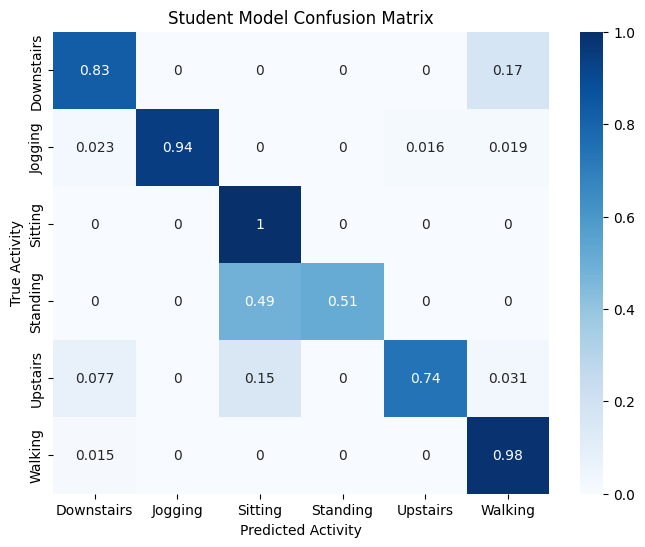

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

student_model.eval()
X_test_tensor = torch.from_numpy(test_X).float().to(device)
with torch.no_grad():
    logits, _ = student_model(X_test_tensor)
    preds = logits.argmax(dim=1).to('cpu').numpy()

cm = confusion_matrix(test_y_idx, preds)
cm = (cm.T / cm.sum(axis=1)).T

print("Classification Report:\n", classification_report(test_y_idx, preds, target_names=unique_classes))
print("Balanced Accuracy:", balanced_accuracy_score(test_y_idx, preds))

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, xticklabels=unique_classes, yticklabels=unique_classes, cmap="Blues")
plt.xlabel("Predicted Activity")
plt.ylabel("True Activity")
plt.title("Student Model Confusion Matrix")

### 6.2 Linear Evaluation

In [13]:
# Modify the student model to extract features (from the conv core output)
def extract_features(model, X):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.from_numpy(X).float().to(device)
        # Forward pass until the features are computed:
        X_tensor = X_tensor.transpose(1, 2)
        x = model.relu(model.conv1(X_tensor))
        x = model.dropout(x)
        x = model.relu(model.conv2(x))
        x = model.dropout(x)
        x = model.relu(model.conv3(x))
        x = F.max_pool1d(x, kernel_size=x.shape[2])
        features = x.squeeze(2)
        return features.to('cpu').numpy()

train_features = extract_features(student_model, train_labeled_X)
test_features = extract_features(student_model, test_X)

from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(train_features, train_labeled_y_idx)
linear_preds = clf.predict(test_features)
linear_acc = np.mean(linear_preds == test_y_idx)
print(f"Linear evaluation accuracy: {linear_acc:.4f}")


Linear evaluation accuracy: 0.9407


/home_as/shared/arbeitsgruppen/flowsim/dependencies/RHEL8/2022.06.0/linux-rhel8-haswell/gcc-11.3.0/py-scikit-learn-1.0.1-72r4tcjwohltlr33uxehss6bdz4thm3a/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
